In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_colwidth', 200)

In [2]:
df = pd.read_csv("data/items.csv")

In [3]:
df.head()

,product_id,order_id,quantity,price_per_unit,segmentation,category,product_name
0,DE-PRO-A1359526,DE-A-80150,1,7.99,DC,drycleaning,Blazer / Jacket
1,DE-PRO-A1359526,DE-Y-69408,1,8.00,DC,drycleaning,Blazer / Jacket
2,DE-PRO-A1359526,DE-C-75730,1,8.00,DC,drycleaning,Blazer / Jacket
3,DE-PRO-A1359526,DE-L-20478,1,8.00,DC,drycleaning,Blazer / Jacket
4,DE-PRO-A1359526,DE-E-01833,1,8.00,DC,drycleaning,Blazer / Jacket


In [4]:
df.sort_values("order_id").head()

,product_id,order_id,quantity,price_per_unit,segmentation,category,product_name
2780,DE-PRO-Y9074269,DE-A-00255,1,5.50,HH,drycleaning,Bed sheet
541,DE-PRO-G4166715,DE-A-00255,1,5.50,HH,drycleaning,Duvet cover
467,DE-PRO-D1330444,DE-A-00255,2,3.00,HH,drycleaning,Pillow case
1992,DE-PRO-V3829751,DE-A-00255,6,2.19,LA,drycleaning,Shirt (on hanger)
1283,DE-PRO-V3829751,DE-A-00873,8,2.19,LA,drycleaning,Shirt (on hanger)


In [5]:
df_orders = pd.read_csv("data/order_churn_data.csv")

C:\Users\Sonia\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
df = df.merge(df_orders[["customer_db_id", "order_id", "order_created_datetime"]])

In [320]:
df.customer_db_id.nunique()

5057

In [13]:
df.sort_values(["customer_db_id", "order_created_datetime"]).head(20)

,product_id,order_id,quantity,price_per_unit,segmentation,category,product_name,customer_db_id,order_created_datetime
7143,GB-PRO-B4003698,GB-S-56080,1,7.5,HH,drycleaning,Bedsheet (double/king/superking),545bf6e0d4cde8f935b78a08,2018-07-05 11:53:54
7144,GB-PRO-D7380614,GB-S-56080,1,9.0,HH,drycleaning,Duvet Cover (double/king/superking),545bf6e0d4cde8f935b78a08,2018-07-05 11:53:54
7145,GB-PRO-R8877223,GB-S-56080,5,2.6,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,2018-07-05 11:53:54
7146,GB-PRO-Y9396610,GB-S-56080,4,2.5,HH,drycleaning,Pillow Case,545bf6e0d4cde8f935b78a08,2018-07-05 11:53:54
6806,GB-PRO-B4003698,GB-H-88727,1,7.5,HH,drycleaning,Bedsheet (double/king/superking),545bf6e0d4cde8f935b78a08,2018-07-13 09:27:00
6807,GB-PRO-R8877223,GB-H-88727,5,2.6,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,2018-07-13 09:27:00
6808,GB-PRO-Y9396610,GB-H-88727,2,2.5,HH,drycleaning,Pillow Case,545bf6e0d4cde8f935b78a08,2018-07-13 09:27:00
6660,GB-PRO-B4003698,GB-L-33028,1,7.5,HH,drycleaning,Bedsheet (double/king/superking),545bf6e0d4cde8f935b78a08,2018-07-17 20:40:03
6661,GB-PRO-R8877223,GB-L-33028,5,2.6,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,2018-07-17 20:40:03
6662,GB-PRO-Y9396610,GB-L-33028,4,2.5,HH,drycleaning,Pillow Case,545bf6e0d4cde8f935b78a08,2018-07-17 20:40:03


In [23]:
df.groupby('product_name')['order_id'].count().sort_values(ascending=False).head()

product_name
Men's Shirt (on hanger)        1779
Shirt (on hanger)              1644
Trousers                       1147
Bag of Folded Laundry (8kg)     959
Suit - 2 pieces                 591
Name: order_id, dtype: int64

In [282]:
unique_prods = df.product_name.sort_values().unique().tolist()
unique_prods

['Apron',
 'Bag of Folded Laundry (8kg)',
 'Bag of Folded Laundry (up to 8kg) ',
 'Bag of Folded Laundry (up to 8kg) - Colour Separation',
 'Bed sheet',
 'Bedsheet',
 'Bedsheet (double/king/superking) ',
 'Bedsheet (single)',
 'Bedspread',
 'Bedspread (double/king/superking) ',
 'Bedspread (single)',
 'Bedspread - large (from 1.20 m in width)',
 'Bedspread - small (up to 1.20 m in width)',
 'Belt',
 'Blanket',
 'Blanket (feather) - large (from 1,40m in width) ',
 'Blanket (feather) - small (up to 1,40m in width) ',
 'Blanket - large (from 1.40 m in width)',
 'Blanket - small (up to 1.40 m in width)',
 'Blazer',
 'Blazer / Jacket',
 'Blouse (no silk, hand ironed)',
 'Blouse - silk (hand ironed)',
 'Blouse/Shirt (Women - Hand ironed)',
 'Blouse/Shirt (hand-finished)',
 'Blouse/Shirt delicate',
 'Bolster',
 'Cardigan',
 'Cashmere / Wool Sweatshirt',
 'Coat ',
 'Coat (full length)',
 'Coat - wool / Raincoat',
 'Colour Separation (per bag)',
 'Cover',
 'Curtain (per curtain)',
 'Curtain del

In [283]:
product_groups = ['Bag of Folded Laundry / Wash & Fold / Colour', 'Bedsheet', 'Bedspread', 'Belt', 'Blanket', 'Blazer / Vest',
                  'Blouse',
                 'Cardigan / Sweater / Jumper / Sweatshirt', 'Coat', 'Curtain', 'Dress / Gown', 'Duvet',
                  'Hat', 'Jacket', 'Mattress', 'Pillow / Bolster',
                 'Polo Shirt', 'Raincoat', 'Scarf', 'Shirt', 'Shorts', 'Skirt', 'Snow suit', 'Sofa / Cover', 'Suit', 
                  'T-shirt', 'Tablecloth / Napkin', 'Tie', 'Top', 'Towel', 'Trousers', 'Underwear']

In [284]:
len(unique_prods)

159

In [285]:
vectorizer = CountVectorizer(unique_prods, ngram_range=(3,5), analyzer='char')
vectorizer.fit(unique_prods)
X = vectorizer.transform(unique_prods).toarray()
y = vectorizer.transform(product_groups).toarray()

In [286]:
similarities = cosine_similarity(X, y)
similarities.shape

(159, 32)

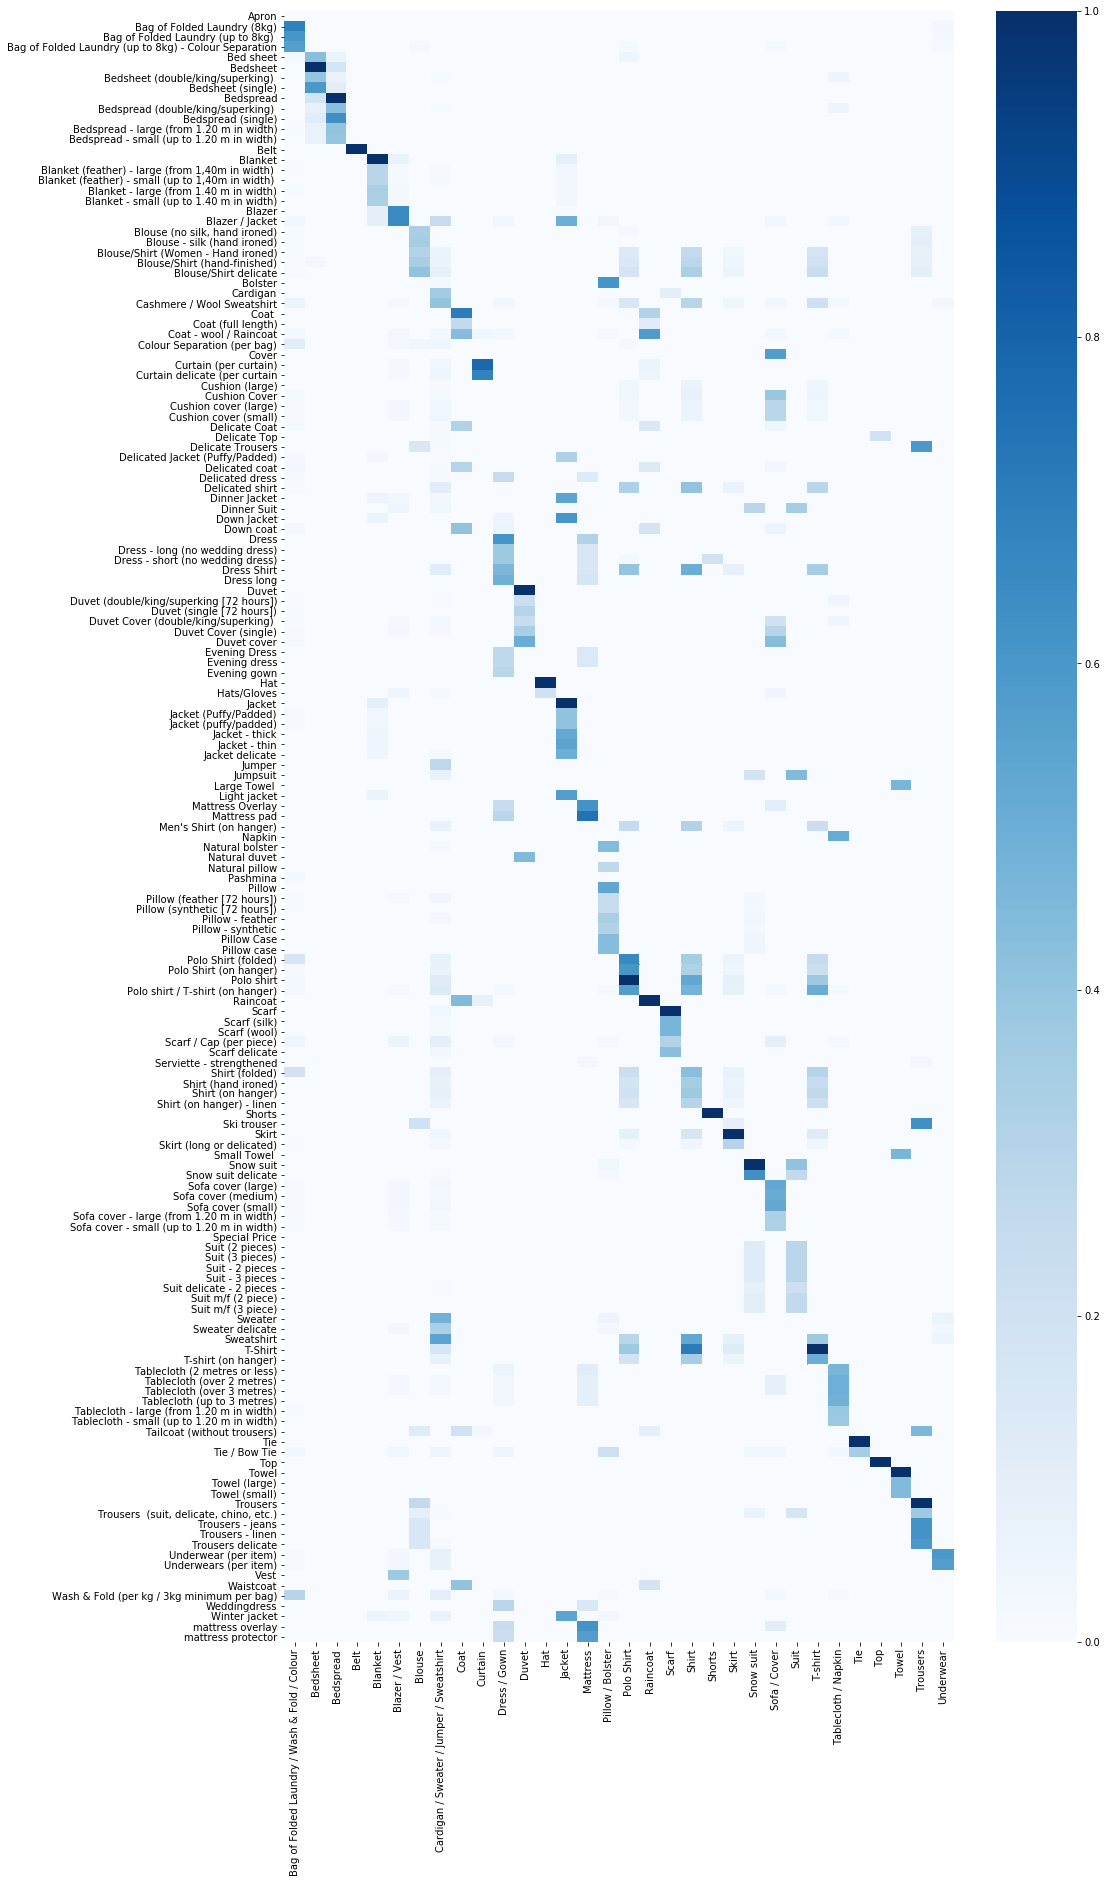

In [287]:
fig, ax = plt.subplots(figsize=(15,30))
sns.heatmap(similarities, xticklabels=product_groups, yticklabels=unique_prods, cmap='Blues')

In [288]:
df_products = pd.DataFrame(data=list(zip(unique_prods, best_matches)), columns=['product_name', 'best_match'])
df_products['product_group'] = df_products['best_match'].apply(lambda x: product_groups[x])
df_products.groupby(['product_group'])['product_name'].apply(lambda x: ','.join(x)).reset_index()

,product_group,product_name
0,Bag of Folded Laundry / Wash & Fold / Colour,"Apron,Bag of Folded Laundry (8kg),Bag of Folded Laundry (up to 8kg) ,Bag of Folded Laundry (up to 8kg) - Colour Separation,Colour Separation (per bag),Napkin,Pashmina,Special Price,Wash & Fold (pe..."
1,Bedsheet,"Bed sheet,Bedsheet,Bedsheet (double/king/superking) ,Bedsheet (single)"
2,Bedspread,"Bedspread,Bedspread (double/king/superking) ,Bedspread (single),Bedspread - large (from 1.20 m in width),Bedspread - small (up to 1.20 m in width)"
3,Belt,Belt
4,Blanket,"Blanket,Blanket (feather) - large (from 1,40m in width) ,Blanket (feather) - small (up to 1,40m in width) ,Blanket - large (from 1.40 m in width),Blanket - small (up to 1.40 m in width)"
5,Blazer / Vest,"Blazer,Blazer / Jacket,Vest"
6,Blouse,"Blouse (no silk, hand ironed),Blouse - silk (hand ironed),Blouse/Shirt (Women - Hand ironed),Blouse/Shirt (hand-finished),Blouse/Shirt delicate"
7,Cardigan / Sweater / Jumper / Sweatshirt,"Cardigan,Cashmere / Wool Sweatshirt,Jumper,Sweater,Sweater delicate,Sweatshirt"
8,Coat,"Coat ,Coat (full length),Delicate Coat,Delicated coat,Down coat,Waistcoat"
9,Curtain,"Curtain (per curtain),Curtain delicate (per curtain"


In [289]:
df = df.merge(df_products, how='left', on='product_name')
df.head()

,product_id,order_id,quantity,price_per_unit,segmentation,category,product_name,customer_db_id,order_created_datetime,best_match,product_group
0,DE-PRO-A1359526,DE-E-89007,1,8.00,DC,drycleaning,Blazer / Jacket,58c7b246457709825a8b459a,2018-07-23 00:31:34,5,Blazer / Vest
1,DE-PRO-V3829751,DE-E-89007,12,2.19,LA,drycleaning,Shirt (on hanger),58c7b246457709825a8b459a,2018-07-23 00:31:34,19,Shirt
2,DE-PRO-A1359526,DE-K-45102,1,8.00,DC,drycleaning,Blazer / Jacket,584c6af1447709ae188b4615,2018-07-22 20:14:29,5,Blazer / Vest
3,DE-PRO-B7280546,DE-K-45102,1,9.00,DC,drycleaning,Dress - short (no wedding dress),584c6af1447709ae188b4615,2018-07-22 20:14:29,10,Dress / Gown
4,DE-PRO-D1679775,DE-K-45102,3,3.50,DC,drycleaning,Shorts,584c6af1447709ae188b4615,2018-07-22 20:14:29,20,Shorts


In [303]:
df_cust = df.groupby(['customer_db_id', 'product_group']).agg({'quantity': 'sum', 'order_id': 'nunique'}).reset_index()
df_cust.head()

,customer_db_id,product_group,quantity,order_id
0,545bf6e0d4cde8f935b78a08,Bedsheet,3,3
1,545bf6e0d4cde8f935b78a08,Duvet,1,1
2,545bf6e0d4cde8f935b78a08,Pillow / Bolster,10,3
3,545bf6e0d4cde8f935b78a08,Shirt,15,3
4,545e000cd4cde8f150245542,Polo Shirt,4,2


In [314]:
df_dumm = pd.get_dummies(df_cust.set_index('customer_db_id')['product_group']).reset_index().groupby(['customer_db_id']).max()
df_dumm.head()

,Bag of Folded Laundry / Wash & Fold / Colour,Bedsheet,Bedspread,Belt,Blanket,Blazer / Vest,Blouse,Cardigan / Sweater / Jumper / Sweatshirt,Coat,Curtain,...,Snow suit,Sofa / Cover,Suit,T-shirt,Tablecloth / Napkin,Tie,Top,Towel,Trousers,Underwear
customer_db_id,,,,,,,,,,,,,,,,,,,,,
545bf6e0d4cde8f935b78a08,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545e000cd4cde8f150245542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5463a2c2d4cde83a4b2ae94c,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
546c7131d4cde8a747fe23b0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
546fa5b0d3cde84376f5db61,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [315]:
X = df_dumm.values

In [348]:
from sklearn.cluster import KMeans

m_km = KMeans(n_clusters=15)
m_km.fit(X)
m_clusters = m_km.labels_.tolist()

In [349]:
df_dumm['cluster'] = m_clusters

In [350]:
df_dumm.head()

,Bag of Folded Laundry / Wash & Fold / Colour,Bedsheet,Bedspread,Belt,Blanket,Blazer / Vest,Blouse,Cardigan / Sweater / Jumper / Sweatshirt,Coat,Curtain,...,Sofa / Cover,Suit,T-shirt,Tablecloth / Napkin,Tie,Top,Towel,Trousers,Underwear,cluster
customer_db_id,,,,,,,,,,,,,,,,,,,,,
545bf6e0d4cde8f935b78a08,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
545e000cd4cde8f150245542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5463a2c2d4cde83a4b2ae94c,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9
546c7131d4cde8a747fe23b0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
546fa5b0d3cde84376f5db61,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4


In [351]:
df_dumm.groupby(['cluster'])['Shirt'].count()

cluster
0      158
1     1177
2      731
3      242
4      562
5      458
6      435
7      143
8      185
9      186
10     105
11     156
12     297
13     119
14     103
Name: Shirt, dtype: int64

In [352]:
centers = pd.DataFrame(data=m_km.cluster_centers_, columns=df_dumm.columns[:-1])
centers

,Bag of Folded Laundry / Wash & Fold / Colour,Bedsheet,Bedspread,Belt,Blanket,Blazer / Vest,Blouse,Cardigan / Sweater / Jumper / Sweatshirt,Coat,Curtain,...,Snow suit,Sofa / Cover,Suit,T-shirt,Tablecloth / Napkin,Tie,Top,Towel,Trousers,Underwear
0,1.000000e+00,6.329114e-03,1.647987e-17,-2.385245e-18,-8.673617e-18,0.031646,1.898734e-02,0.018987,-6.938894e-18,2.602085e-18,...,8.673617e-18,-5.204170e-18,2.531646e-02,9.493671e-02,-1.040834e-17,2.428613e-17,3.797468e-02,-1.908196e-17,2.775558e-16,6.329114e-03
1,-2.359224e-15,1.699235e-03,8.496177e-04,-1.051676e-17,8.496177e-04,0.034834,2.275957e-15,0.031436,5.947324e-03,6.505213e-18,...,8.496177e-04,8.496177e-04,3.774758e-15,2.209006e-02,1.699235e-03,4.248088e-03,1.529312e-02,8.496177e-04,-5.440093e-15,1.104503e-02
2,1.000000e+00,2.735978e-03,1.367989e-03,3.361027e-18,1.367989e-03,0.001368,4.103967e-03,0.006840,1.367989e-03,1.367989e-03,...,-3.122502e-17,1.367989e-03,1.094391e-02,9.575923e-03,1.367989e-03,-4.232725e-16,4.103967e-03,2.735978e-03,5.471956e-03,1.367989e-03
3,4.958678e-02,4.132231e-03,8.264463e-03,1.652893e-02,-1.474515e-17,0.152893,3.305785e-01,0.095041,8.264463e-02,8.264463e-03,...,3.719008e-02,8.673617e-18,-6.106227e-16,2.066116e-02,1.734723e-17,2.428613e-17,2.081668e-16,4.132231e-03,2.768595e-01,8.264463e-03
4,1.779359e-03,-3.400058e-16,1.779359e-03,7.372575e-18,1.344411e-17,0.085409,1.779359e-02,0.008897,2.846975e-02,8.673617e-19,...,3.558719e-03,1.779359e-03,1.000000e+00,3.558719e-03,-1.561251e-17,4.804270e-02,5.338078e-03,1.908196e-17,1.530249e-01,5.338078e-03
5,2.109424e-15,-3.191891e-16,2.183406e-03,4.011548e-18,-2.602085e-18,0.087336,-3.053113e-16,0.069869,1.528384e-02,-2.602085e-18,...,4.366812e-03,4.336809e-18,1.998401e-15,6.986900e-02,4.366812e-03,2.838428e-02,4.148472e-02,2.183406e-03,1.000000e+00,1.528384e-02
6,5.517241e-02,4.597701e-03,2.298851e-03,3.144186e-18,2.298851e-03,0.059770,2.298851e-02,0.039080,1.839080e-02,-1.951564e-18,...,2.298851e-03,7.806256e-18,1.000000e+00,1.379310e-02,6.896552e-03,5.287356e-02,4.597701e-03,7.632783e-17,1.998401e-15,1.379310e-02
7,1.048951e-01,6.993007e-03,1.398601e-02,-2.059984e-18,-6.938894e-18,0.370629,1.118881e-01,0.251748,8.391608e-02,1.517883e-18,...,6.938894e-18,6.993007e-03,2.027972e-01,2.097902e-02,-9.540979e-18,2.097902e-02,1.000000e+00,-1.734723e-17,3.986014e-01,3.496503e-02
8,1.621622e-01,8.972973e-01,5.405405e-02,-2.818926e-18,1.621622e-02,0.032432,5.405405e-02,0.059459,1.081081e-02,4.119968e-18,...,5.405405e-03,1.081081e-02,9.729730e-02,1.081081e-01,2.702703e-02,5.405405e-03,9.729730e-02,1.351351e-01,2.270270e-01,4.864865e-02
9,1.612903e-02,1.075269e-02,5.376344e-03,-2.818926e-18,-1.127570e-17,0.118280,1.000000e+00,0.096774,4.838710e-02,4.336809e-18,...,3.225806e-02,-3.469447e-18,-4.440892e-16,3.763441e-02,2.150538e-02,3.225806e-02,4.838710e-02,5.376344e-03,4.462366e-01,-2.602085e-17


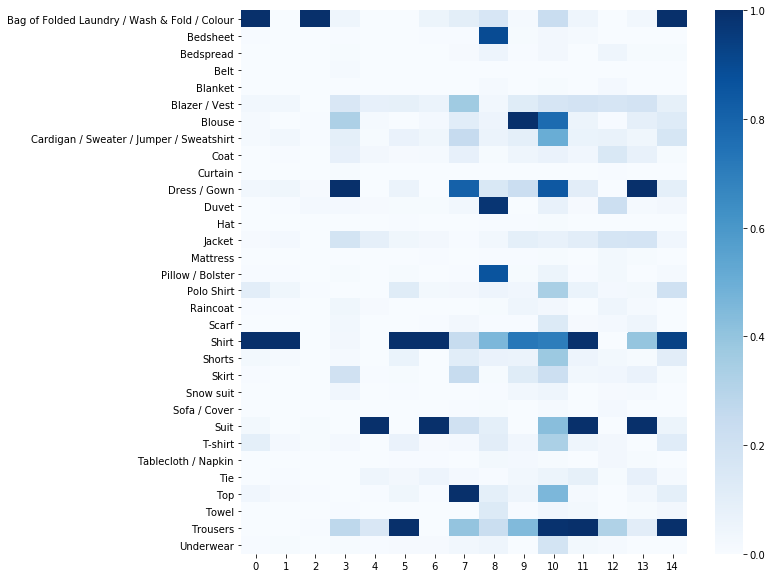

In [353]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(centers.T, cmap='Blues', yticklabels=centers.columns)